In [ ]:
import shutil
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from scipy.io import wavfile
from tqdm import tqdm

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.models import Sequential
from keras.utils import to_categorical, normalize
from keras.layers import Conv1D, Dense, LSTM, Flatten, Dropout, MaxPooling1D


# Looking into Patients and their Diagnosis

In [ ]:
diagnosis_df = pd.read_csv('patient_diagnosis.csv', names=['Patient number', 'Diagnosis'])
diagnosis_df.head()

,Patient number,Diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


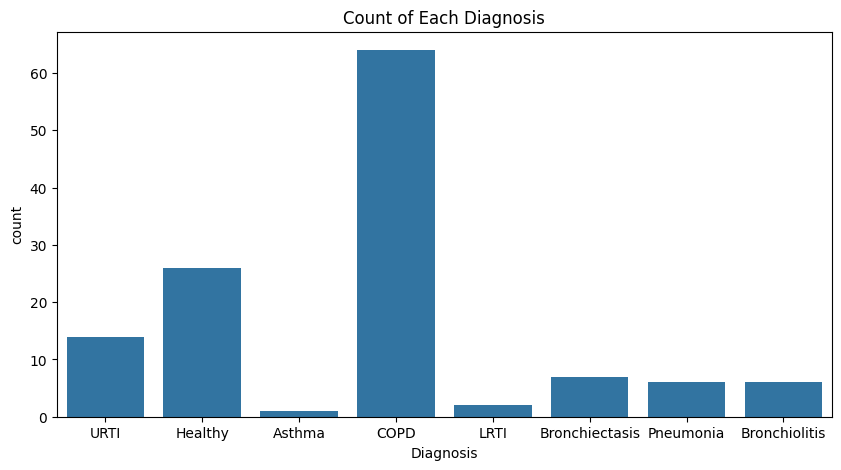

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Diagnosis', data=diagnosis_df)
plt.title('Count of Each Diagnosis')
plt.show()

# Looking into Patient's Metadata

In [ ]:
patient_df = pd.read_csv('demographic_info.txt',
                         names=['Patient number', 'Age', 'Sex', 'Adult BMI (kg/m2)', 'Child Weight (kg)', 'Child Height (cm)'],
                         delimiter=' ')

In [ ]:
patient_df.head()

,Patient number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm)
0,101,3.00,F,NaN,19.0,99.0
1,102,0.75,F,NaN,9.8,73.0
2,103,70.00,F,33.00,NaN,NaN
3,104,70.00,F,28.47,NaN,NaN
4,105,7.00,F,NaN,32.0,135.0


In [ ]:
patient_df['Adult BMI (kg/m2)'].isna().sum()

np.int64(51)

In [ ]:
for i in range(len(patient_df)):
    if pd.isna(patient_df.loc[i, 'Adult BMI (kg/m2)']) and not pd.isna(patient_df.loc[i, 'Child Weight (kg)']) and not pd.isna(patient_df.loc[i, 'Child Height (cm)']):
        patient_df.at[i, 'Adult BMI (kg/m2)'] = round(patient_df.loc[i, 'Child Weight (kg)'] / np.square(0.01 * patient_df.loc[i, 'Child Height (cm)']), 2)

In [ ]:
patient_df['Adult BMI (kg/m2)'].isna().sum()

np.int64(9)

In [ ]:
df = pd.merge(left=patient_df, right=diagnosis_df, on='Patient number', how='left')
df.head()

,Patient number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm),Diagnosis
0,101,3.00,F,19.39,19.0,99.0,URTI
1,102,0.75,F,18.39,9.8,73.0,Healthy
2,103,70.00,F,33.00,NaN,NaN,Asthma
3,104,70.00,F,28.47,NaN,NaN,COPD
4,105,7.00,F,17.56,32.0,135.0,URTI


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Update the folder path for Google Colab
folder_path = '/content/drive/MyDrive/audio_and_txt_files'

Patient_numbers, Recording_indices, Chest_locations, Acquisition_modes, Recording_equipments = [], [], [], [], []

for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        parts = filename.split('_')
        Patient_number = parts[0]
        Recording_index = parts[1]
        Chest_location = parts[2]
        Acquisition_mode = parts[3]
        Recording_equipment = parts[4].split('.')[0]

        Patient_numbers.append(int(Patient_number))
        Recording_indices.append(Recording_index)
        Chest_locations.append(Chest_location)
        Acquisition_modes.append(Acquisition_mode)
        Recording_equipments.append(Recording_equipment)

df1 = pd.DataFrame({
    'Patient number': Patient_numbers,
    'Recording index': Recording_indices,
    'Chest location': Chest_locations,
    'Acquisition mode': Acquisition_modes,
    'Recording equipment': Recording_equipments
})

df1.tail()

Mounted at /content/drive


,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment
925,160,1b2,Pr,mc,AKGC417L
926,160,1b2,Al,mc,AKGC417L
927,160,1b2,Ar,mc,AKGC417L
928,160,1b2,Tc,mc,AKGC417L
929,160,1b3,Pl,mc,AKGC417L


# Merging all the data

In [ ]:
# Merging the dataframes
df_all = pd.merge(left=df1, right=df, how='left').sort_values('Patient number').reset_index(drop=True)

# Display the first few rows
df_all.head()

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm),Diagnosis
0,101,1b1,Pr,sc,Meditron,3.00,F,19.39,19.0,99.0,URTI
1,101,1b1,Al,sc,Meditron,3.00,F,19.39,19.0,99.0,URTI
2,102,1b1,Ar,sc,Meditron,0.75,F,18.39,9.8,73.0,Healthy
3,103,2b2,Ar,mc,LittC2SE,70.00,F,33.00,NaN,NaN,Asthma
4,104,1b1,Pl,sc,Litt3200,70.00,F,28.47,NaN,NaN,COPD


In [ ]:
# Generating the audio file names in Google Colab
df_all['audio_file_name'] = df_all.apply(lambda row: f"{row['Patient number']}_{row['Recording index']}_{row['Chest location']}_"
                                         f"{row['Acquisition mode']}_{row['Recording equipment']}.wav", axis=1)

In [ ]:
# Selecting relevant columns for the main dataframe
df_main = df_all[['Patient number', 'audio_file_name', 'Diagnosis']]
df_main.head(20)

,Patient number,audio_file_name,Diagnosis
0,101,101_1b1_Pr_sc_Meditron.wav,URTI
1,101,101_1b1_Al_sc_Meditron.wav,URTI
2,102,102_1b1_Ar_sc_Meditron.wav,Healthy
3,103,103_2b2_Ar_mc_LittC2SE.wav,Asthma
4,104,104_1b1_Pl_sc_Litt3200.wav,COPD
5,104,104_1b1_Lr_sc_Litt3200.wav,COPD
6,104,104_1b1_Ll_sc_Litt3200.wav,COPD
7,104,104_1b1_Ar_sc_Litt3200.wav,COPD
8,104,104_1b1_Pr_sc_Litt3200.wav,COPD
9,104,104_1b1_Al_sc_Litt3200.wav,COPD


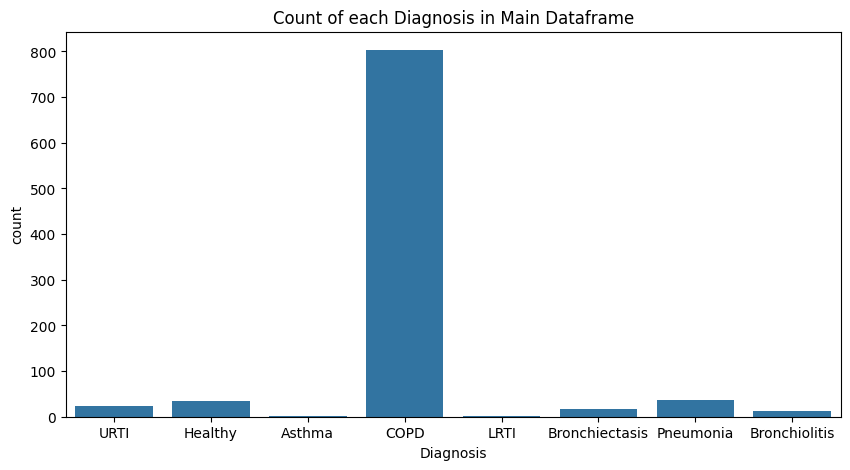

In [ ]:
# Plotting the count of each diagnosis
plt.figure(figsize=(10, 5))
sns.countplot(data=df_main, x='Diagnosis')
plt.title('Count of each Diagnosis in Main Dataframe')
plt.show()

# Removing 'Asthma' and 'LRTI' records entirely from dataframe as they are very low in number. 'COPD' is heavily sampled. We'll deal with undersampling and oversampling the rest down the line.

In [ ]:
# Removing records with 'Asthma' and 'LRTI' diagnoses
df_main = df_main[(df_main['Diagnosis'] != 'Asthma') & (df_main['Diagnosis'] != 'LRTI')]

# Sorting the dataframe by 'Patient number' and resetting the index
df_main = df_main.sort_values('Patient number').reset_index(drop=True)

In [ ]:
# Displaying the count of each Diagnosis after filtering
df_main['Diagnosis'].value_counts()


,count
Diagnosis,
COPD,803
Pneumonia,37
Healthy,35
URTI,23
Bronchiectasis,16
Bronchiolitis,13


In [ ]:
# Displaying the percentage distribution of each Diagnosis
df_main['Diagnosis'].value_counts(normalize=True) * 100

,proportion
Diagnosis,
COPD,86.623517
Pneumonia,3.991370
Healthy,3.775620
URTI,2.481122
Bronchiectasis,1.725998
Bronchiolitis,1.402373


In [ ]:
df_main.head(10)

,Patient number,audio_file_name,Diagnosis
0,101,101_1b1_Pr_sc_Meditron.wav,URTI
1,101,101_1b1_Al_sc_Meditron.wav,URTI
2,102,102_1b1_Ar_sc_Meditron.wav,Healthy
3,104,104_1b1_Pl_sc_Litt3200.wav,COPD
4,104,104_1b1_Al_sc_Litt3200.wav,COPD
5,104,104_1b1_Ar_sc_Litt3200.wav,COPD
6,104,104_1b1_Ll_sc_Litt3200.wav,COPD
7,104,104_1b1_Lr_sc_Litt3200.wav,COPD
8,104,104_1b1_Pr_sc_Litt3200.wav,COPD
9,105,105_1b1_Tc_sc_Meditron.wav,URTI


# Looking into Audio Files

In [ ]:
from glob import glob
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set the audio files path from Google Drive
audio_files_path = '/content/drive/MyDrive/audio_and_txt_files/'
audio_files = glob(os.path.join(audio_files_path, '**/*.wav'), recursive=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
len(audio_files)

920

In [ ]:
# Example Audio File
ipd.Audio(audio_files[0])

In [ ]:
import librosa

# Load the first audio file
y, sr = librosa.load(audio_files[0])

# Print the length of the audio signal and the sample rate
print(len(y))
print(sr)

441000
22050


In [ ]:
classes = list(df_main['Diagnosis'].unique())
print(classes)

['URTI', 'Healthy', 'COPD', 'Bronchiectasis', 'Pneumonia', 'Bronchiolitis']


# Preprocessing the Audio Files

In [ ]:
# Envelope refers to a curve that represents the variation over time of a certain characteristic of the audio signal.
# The envelope is often used to capture the general shape or magnitude of the signal, helping to highlight its dynamic changes.

def envelope(y, sr, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_rolling = y.rolling(window=int(sr / 10), min_periods=1, center=True).mean()
    for i in y_rolling:
        if i > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [ ]:
# Mounting Google Drive to access and save files
from google.colab import drive
drive.mount('/content/drive')

# Creating a folder in Google Drive to add cleaned audio files
folder_path = '/content/drive/MyDrive/wavfiles_cleaned'
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)

os.makedirs(folder_path, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Correct file names by removing '(1)' regardless of spacing
df_main['audio_file_name'] = df_main['audio_file_name'].str.replace(r'\(1\)', '', regex=True)

# Verify that all files now exist
missing_files_after_fix = [
    f for f in df_main['audio_file_name']
    if not os.path.exists(os.path.join(audio_files_path, f))
]

print("Files still missing after correction:", missing_files_after_fix)


Files still missing after correction: []


In [ ]:
import os

# Ensure the cleaned audio folder exists
os.makedirs('/content/drive/MyDrive/wavfiles_cleaned/', exist_ok=True)

In [ ]:
from tqdm import tqdm
from scipy.io import wavfile
import librosa
import numpy as np
import os

# Paths to your audio files and cleaned files
audio_files_path = '/content/drive/MyDrive/audio_and_txt_files/'
cleaned_audio_path = '/content/drive/MyDrive/wavfiles_cleaned/'

# Ensure the cleaned audio folder exists
os.makedirs(cleaned_audio_path, exist_ok=True)

# Processing the audio files
for i in tqdm(df_main['audio_file_name']):
    y, sr = librosa.load(audio_files_path + str(i), sr=22050)
    mask = envelope(y, sr, 0.0005)
    wavfile.write(filename=cleaned_audio_path + str(i), rate=sr, data=(y[mask] * 32767).astype(np.int16))

100%|██████████| 927/927 [03:14<00:00,  4.76it/s]


In [ ]:
import os
import librosa
import numpy as np

# Function to parse and extract features from audio files
def parser(row):
    # Update the file path to point to your Google Drive directory
    audio_file_name = os.path.join('/content/drive/MyDrive/wavfiles_cleaned', str(row['audio_file_name']))

    # Load the audio file
    y, sr = librosa.load(audio_file_name, sr=22050)

    # Extract existing features
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=24).T, axis=0)
    chromagrams = np.mean(librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=24).T, axis=0)
    mel_specs = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
    spec_contrasts = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr, n_bands=6).T, axis=0)
    tonal_centroids = np.mean(librosa.feature.tonnetz(y=y, sr=sr).T, axis=0)

    # Extract NEW features (Fix applied: taking mean and flattening)
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr), axis=1).flatten()
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y), axis=1).flatten()
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr), axis=1).flatten()

    # Concatenate all features into a single array
    features = np.concatenate([
        mfccs, chromagrams, mel_specs, spec_contrasts, tonal_centroids,
        spectral_bandwidth, zero_crossing_rate, spectral_rolloff
    ], axis=0)

    # Retrieve the label (diagnosis)
    labels = row['Diagnosis']

    return [features, labels]

In [ ]:
# Apply the parser function to each row and convert the result to a list
data = df_main.apply(parser, axis=1).tolist()
data[0]

[array([-5.82514221e+02,  9.53991470e+01,  5.73978767e+01,  3.14288712e+01,
         2.81439571e+01,  3.35223999e+01,  3.15645218e+01,  2.27909431e+01,
         1.66458950e+01,  1.56335859e+01,  1.40267839e+01,  9.26816368e+00,
         5.85131645e+00,  7.34529257e+00,  1.05778170e+01,  1.06101179e+01,
         7.15884209e+00,  3.72958350e+00,  2.66777682e+00,  3.64833450e+00,
         5.49226475e+00,  7.36752129e+00,  8.09984398e+00,  6.51004505e+00,
         7.66114295e-01,  7.88513541e-01,  8.08201253e-01,  8.26666117e-01,
         8.47371519e-01,  8.70164037e-01,  8.90980601e-01,  9.11121547e-01,
         9.24383104e-01,  9.25170243e-01,  9.07725036e-01,  8.73850942e-01,
         8.38790238e-01,  8.10901642e-01,  7.83290505e-01,  7.59082496e-01,
         7.40757167e-01,  7.26198792e-01,  7.11273849e-01,  6.97630048e-01,
         6.86746478e-01,  6.75771177e-01,  6.90761387e-01,  7.33651638e-01,
         1.74603863e+01,  2.01245785e+00,  1.98306546e-01,  6.75304830e-02,
         3.5

In [ ]:
X = np.array(list(zip(*data))[0])
y = np.array(list(zip(*data))[1])

In [ ]:
df_main['Diagnosis'].value_counts()

,count
Diagnosis,
COPD,803
Pneumonia,37
Healthy,35
URTI,23
Bronchiectasis,16
Bronchiolitis,13


# Resampling. We have downsized 'COPD' records by eliminating half of them randomly and oversampled the minority classes using SMOTE.

In [ ]:
# Step 1: Install the imbalanced-learn library for SMOTE
!pip install imbalanced-learn

# Step 2: Import necessary libraries
from imblearn.over_sampling import SMOTE
import numpy as np

# Step 3: Define the desired number of samples per minority class for over-sampling
sampling_strategy_over = {
    'Pneumonia': 150,
    'Healthy': 150,
    'URTI': 100,
    'Bronchiectasis': 100,
    'Bronchiolitis': 100
}

# Step 4: Create the SMOTE object for over-sampling minority classes
smote = SMOTE(sampling_strategy=sampling_strategy_over, k_neighbors=5, random_state=42)

# Step 5: Apply SMOTE to oversample minority classes
X_resampled_over, y_resampled_over = smote.fit_resample(X, y)

# Step 6: Remove half of the "COPD" samples to balance the dataset
copd_indices = np.where(y_resampled_over == 'COPD')[0]  # Find indices of 'COPD' samples
np.random.seed(42)  # For reproducibility
np.random.shuffle(copd_indices)  # Shuffle the indices

# Determine indices to remove (half of the 'COPD' samples)
remove_indices = copd_indices[:len(copd_indices) // 2]

# Remove selected 'COPD' samples from the dataset
X_resampled = np.delete(X_resampled_over, remove_indices, axis=0)
y_resampled = np.delete(y_resampled_over, remove_indices)

# Step 7: Check the new class distribution
from collections import Counter
print("Resampled Class Distribution:", Counter(y_resampled))

Resampled Class Distribution: Counter({np.str_('COPD'): 402, np.str_('Healthy'): 150, np.str_('Pneumonia'): 150, np.str_('URTI'): 100, np.str_('Bronchiectasis'): 100, np.str_('Bronchiolitis'): 100})


In [ ]:
# Final count of all classes
np.unique(y_resampled, return_counts=True)

(array(['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia',
        'URTI'], dtype='<U14'),
 array([100, 100, 402, 150, 150, 100]))

In [ ]:
print('Shape of X is',X_resampled.shape)
print('Shape of y is',y_resampled.shape)

Shape of X is (1002, 192)
Shape of y is (1002,)


In [ ]:
# Encoding the target variables
le = LabelEncoder()
y_encoded = le.fit_transform(y_resampled)
y_resampled = to_categorical(y_encoded)

In [ ]:
y_resampled[0]

array([0., 0., 0., 0., 0., 1.])

In [ ]:
# Splitting the data into Train and Test in 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Get the correct number of features
feature_count = X_train.shape[1]

# Reshape training data
# Ensure input shape is (samples, time_steps, channels)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
print("X_train shape:", X_train.shape)
print("X_train_reshaped shape:", X_train_reshaped.shape)

X_train shape: (801, 192)
X_train_reshaped shape: (801, 192, 1)


In [ ]:
# Step 1: Install TensorFlow if not already installed
!pip install tensorflow

# Step 2: Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Flatten, Dense

# Step 3: Define the input shape
input_shape = (189, 1)  # (timesteps, features)

# Step 4: Build the model
model = Sequential()

# 1st Convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(192, 1)))  # Correct input shape


# Dropout layer for regularization
model.add(Dropout(0.5))

# Flatten layer to convert 3D tensor to 2D
model.add(Flatten())

# Dense layer with softmax activation for multi-class classification
model.add(Dense(6, activation='softmax'))

# Step 5: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 6: Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 190, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 190, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12160)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │          72,966 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,222 (286.02 KB)

 Trainable params: 73,222 (286.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.fit(X_train_reshaped, y_train, batch_size=64, epochs=200, validation_split=0.25, verbose=0)

In [ ]:
# Performance on Test set
model.evaluate(X_test_reshaped, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8920 - loss: 0.3386  


[0.35521847009658813, 0.9004974961280823]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


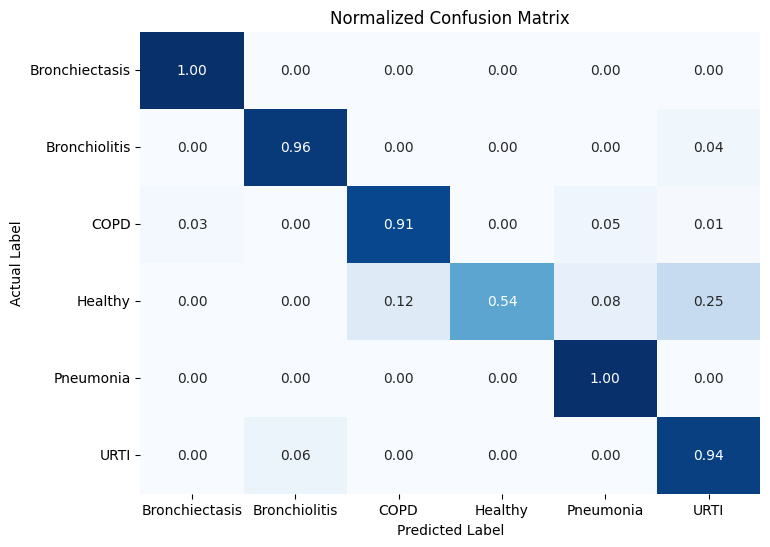

In [ ]:
predictions = model.predict(X_test_reshaped)

# Convert predicted probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Step : Ensure y_test is correctly formatted (one-hot to class labels)
# If y_test is one-hot encoded, convert it back to class labels for comparison
actual_classes = np.argmax(y_test, axis=1)  # Ensure y_test is one-hot encoded before this step

# Step : Generate the Confusion Matrix
conf_matrix = confusion_matrix(actual_classes, predicted_classes)

# Normalize the confusion matrix
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Step : Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_, cbar=False)

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
# Classification Report
print(classification_report(np.argmax(y_test, axis=1), predicted_classes))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        28
           1       0.96      0.96      0.96        25
           2       0.96      0.91      0.94        79
           3       1.00      0.54      0.70        24
           4       0.82      1.00      0.90        28
           5       0.67      0.94      0.78        17

    accuracy                           0.90       201
   macro avg       0.89      0.89      0.87       201
weighted avg       0.92      0.90      0.90       201



# LSTM Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Flatten, MaxPooling1D

input_shape = (192, 1)  # (time_steps, features)

model = Sequential()

# LSTM layers
model.add(LSTM(units=1024, return_sequences=True, input_shape=input_shape))
model.add(Dropout(0.5))

model.add(LSTM(units=512, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(units=256, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.5))

# MaxPooling1D layer
model.add(MaxPooling1D(pool_size=2))  # Reduces time steps from 192 to 96

# Flatten layer to convert 3D to 2D
model.add(Flatten())  # Converts (96, 32) -> (3072,)

# Dense layers
model.add(Dense(units=100, activation='relu'))  # First dense layer expects 3072 input units
model.add(Dense(units=6, activation='softmax'))  # 6 output classes

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 192, 1024)           │       4,202,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 192, 1024)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 192, 512)            │       3,147,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 192, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 192, 256)            │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 192, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 192, 128)            │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 192, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 192, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 192, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 192, 32)             │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 192, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 96, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │         307,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             606 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,704,578 (33.21 MB)

 Trainable params: 8,704,578 (33.21 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train_reshaped, y_train, batch_size=64, epochs=200, validation_split=0.25, verbose=0)

In [ ]:
# Performance on Test set
model.evaluate(X_test_reshaped, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9019 - loss: 0.3951


[0.36754798889160156, 0.9104477763175964]

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


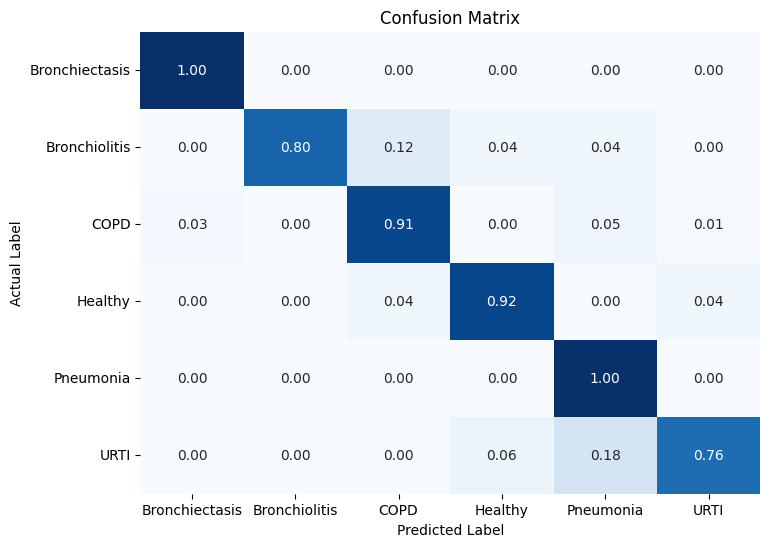

In [ ]:
# Confusion Matrix
predictions = model.predict(X_test_reshaped)

predicted_classes = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes)
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification Report
print(classification_report(np.argmax(y_test, axis=1), predicted_classes))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        28
           1       1.00      0.80      0.89        25
           2       0.95      0.91      0.93        79
           3       0.92      0.92      0.92        24
           4       0.78      1.00      0.88        28
           5       0.87      0.76      0.81        17

    accuracy                           0.91       201
   macro avg       0.91      0.90      0.90       201
weighted avg       0.92      0.91      0.91       201



# CNN-LSTM Model

In [ ]:
# Define input shape
input_shape = (192, 1)  # Matches (801, 192, 1) from X_train_reshaped

# Creating the Sequential model
model = Sequential()

# Adding Conv1D layers with dropout
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))

# Adding LSTM layers with dropout
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.5))

# Adding MaxPooling1D layer
model.add(MaxPooling1D(pool_size=2))

# Flatten layer
model.add(Flatten())

# Dense layers
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 190, 128)            │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 188, 64)             │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 188, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 188, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 188, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 188, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 188, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 94, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6016)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │         601,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 6)                   │             606 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 775,682 (2.96 MB)

 Trainable params: 775,682 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train_reshaped, y_train, batch_size=64, epochs=200, validation_split=0.25, verbose=0)

In [ ]:
# Performance on Test set
model.evaluate(X_test_reshaped, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9229 - loss: 0.4004


[0.5759168863296509, 0.9104477763175964]

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


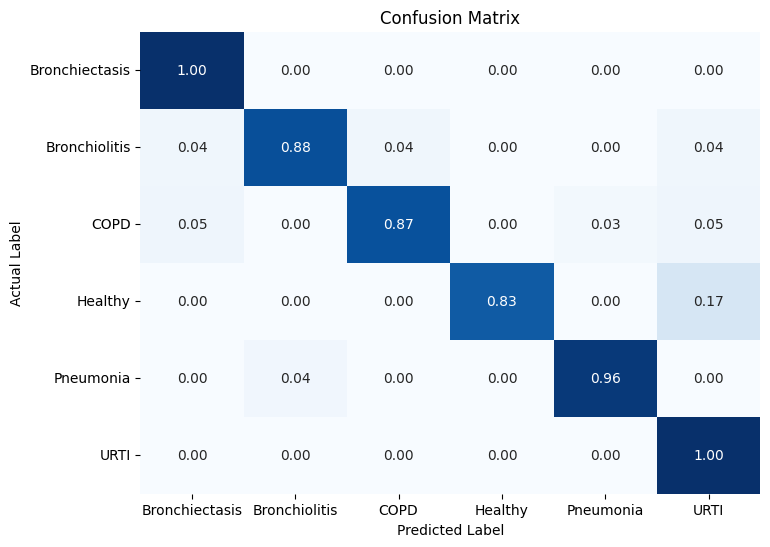

In [ ]:
# Confusion Matrix
predictions = model.predict(X_test_reshaped)

predicted_classes = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes)
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification Report
print(classification_report(np.argmax(y_test, axis=1), predicted_classes))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        28
           1       0.96      0.88      0.92        25
           2       0.99      0.87      0.93        79
           3       1.00      0.83      0.91        24
           4       0.93      0.96      0.95        28
           5       0.65      1.00      0.79        17

    accuracy                           0.91       201
   macro avg       0.90      0.93      0.90       201
weighted avg       0.93      0.91      0.91       201



# CNN-GRU with Attention


In [ ]:
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
input_shape = (X_train_reshaped.shape[1], 1)  # (timesteps, features)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, GRU, Dropout, Dense, Flatten, MaxPooling1D, Attention, ZeroPadding1D, Input, Lambda

# Define input shape
input_shape = (192, 1)

# Create the model
input_tensor = Input(shape=input_shape)

x = ZeroPadding1D(padding=(1, 1))(input_tensor)  # Add padding
x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = Dropout(0.5)(x)
x = GRU(units=128, return_sequences=True)(x)
x = Dropout(0.5)(x)
x = GRU(units=64, return_sequences=True)(x)
x = Dropout(0.5)(x)

# Create query and value tensors
query = x
value = x

# Apply attention
attention_output = Attention()([query, value])  # Provide query and value inputs

x = MaxPooling1D(pool_size=2)(attention_output)
x = Flatten()(x)
x = Dense(units=100, activation='relu')(x)
output_tensor = Dense(units=6, activation='softmax')(x)

# Create the model
model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 192, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding1d_2          │ (None, 194, 1)         │              0 │ input_layer_5[0][0]    │
│ (ZeroPadding1D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 192, 128)       │            512 │ zero_padding1d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_10 (Conv1D)        │ (None, 190, 64)        │         24,640 │ conv1d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 190, 64)        │              0 │ conv1d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_8 (GRU)               │ (None, 190, 128)       │         74,496 │ dropout_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 190, 128)       │              0 │ gru_8[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_9 (GRU)               │ (None, 190, 64)        │         37,248 │ dropout_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout)      │ (None, 190, 64)        │              0 │ gru_9[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_4 (Attention)   │ (None, 190, 64)        │              0 │ dropout_15[0][0],      │
│                           │                        │                │ dropout_15[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_4           │ (None, 95, 64)         │              0 │ attention_4[0][0]      │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 6080)           │              0 │ max_pooling1d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 100)            │        608,100 │ flatten_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 6)              │            606 │ dense_9[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 745,602 (2.84 MB)

 Trainable params: 745,602 (2.84 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
model.fit(X_train_reshaped, y_train, batch_size=64, epochs=200, validation_split=0.25, verbose=0)

In [51]:

# Evaluate the model
model.evaluate(X_test_reshaped, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9510 - loss: 0.1846


[0.2181829810142517, 0.9402984976768494]

In [54]:
predictions = model.predict(X_test_reshaped)  # Or your model's prediction method

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Ensure y_test is correctly formatted
actual_classes = np.argmax(y_test, axis=1)  # If y_test is one-hot encoded

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


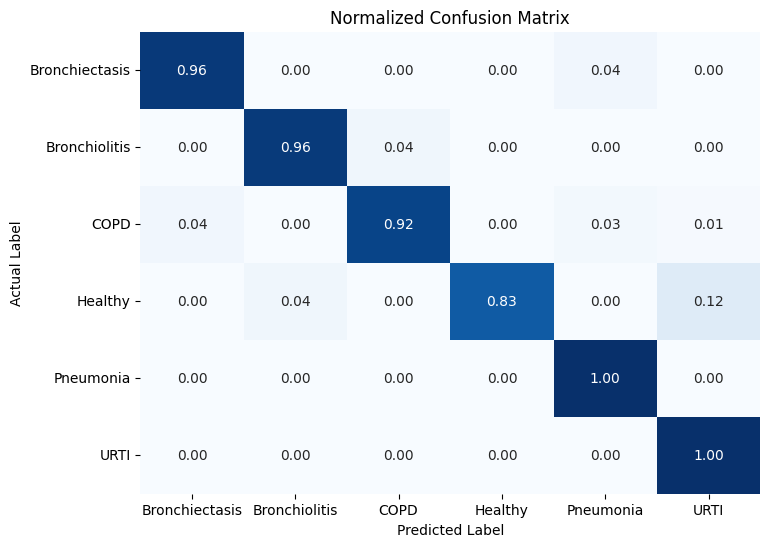

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(actual_classes, predicted_classes)
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Normalized Confusion Matrix')
plt.show()

In [56]:
# classification report
from sklearn.metrics import classification_report

print(classification_report(actual_classes, predicted_classes, target_names=le.classes_))

                precision    recall  f1-score   support

Bronchiectasis       0.90      0.96      0.93        28
 Bronchiolitis       0.96      0.96      0.96        25
          COPD       0.99      0.92      0.95        79
       Healthy       1.00      0.83      0.91        24
     Pneumonia       0.90      1.00      0.95        28
          URTI       0.81      1.00      0.89        17

      accuracy                           0.94       201
     macro avg       0.93      0.95      0.93       201
  weighted avg       0.95      0.94      0.94       201

